In [1]:
import pywt
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense , Input , LSTM, Bidirectional, Dropout
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras import regularizers
#from utility_function import autoencoder

In [2]:
def wavelet_transform(df):
    ca , cb, cc , cd = pywt.wavedec(df['price'].values, 'haar', level = 3)
    cat = pywt.threshold(ca, np.std(ca), mode = 'soft')
    cbt = pywt.threshold(cb, np.std(cb), mode = 'soft')
    cct = pywt.threshold(cc, np.std(cc), mode = 'soft')
    cdt = pywt.threshold(cd, np.std(cd), mode = 'soft')
    coeff = [cat , cbt, cct , cdt]
    return pywt.waverec(coeff, 'haar')

def get_sample(df, length, temporal_horizon):

    temporal_horizon = temporal_horizon - 1
    last_possible = df.shape[0] - temporal_horizon - length

    random_start = np.random.randint(0, last_possible)
    X_sample = df.drop(columns = 'price')[random_start: random_start+length].values
    y_sample = df['price'][random_start+length: random_start+length+temporal_horizon+1]
    
   # if y_sample != y_sample:
        #X_sample, y_sample = get_sample(df, length, temporal_horizon)
    
    return X_sample, y_sample

def get_X_y(df, temporal_horizon, length_of_sequences):
    X, y = [], []

    for len_ in length_of_sequences:
        xi, yi = get_sample(df, len_, temporal_horizon)
        X.append(xi)
        y.append(yi)
        
    return X, np.array(y)


def autoencoder(features):
    input_data = Input(shape=(1, features))
    encoded1 = Dense(features, activation="relu", activity_regularizer=regularizers.l2(0))(input_data)
    one_l = Dense(1, activation="relu", activity_regularizer=regularizers.l2(0))(encoded1)
    decoded = Dense(features, activation="linear", activity_regularizer=regularizers.l2(0))(one_l)
    autoencoder = Model(inputs=input_data, outputs=decoded)
    encoder = Model(input_data, one_l)
    autoencoder.compile(loss = 'mse', optimizer = 'rmsprop',metrics = ['mae'])
    return autoencoder , encoder

def init_model() :
    model = Sequential()               
    model.add(LSTM(150,activation = 'tanh',input_shape=(length, 14),return_sequences = True))
    model.add(Dropout(0.5))  
    model.add(Bidirectional(LSTM(120, activation = 'tanh',return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(100,activation = 'tanh',return_sequences = True)))
    model.add(Dropout(0.5))
    model.add(LSTM(80,activation = 'tanh'))
    model.add(Dense(60,activation = 'relu'))     
    model.add(Dense(n_days,activation = 'linear'))

    model.compile(loss = 'mse', optimizer = 'rmsprop',metrics = ['mae'])

    return model

## DATA

In [3]:
df  = pd.read_csv('ma_ema.csv')
df.set_index('date', inplace = True)
df_test = df[2970:3361]
df = df[:3000]

In [4]:
df['price'] = wavelet_transform(df)
df.dropna(inplace = True)

## AUTOENCODER

In [5]:
autoencoder,encoder = autoencoder(14)

In [6]:
X = np.array(df)
X = X.reshape(len(X), 1, 14)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor = 'val_loss',mode = 'min' , verbose = 1, patience = 20, restore_best_weights = True)
history = autoencoder.fit(X,X,
                    validation_split = 0.3,
                   callbacks = [es], 
                   epochs = 1000, 
                   batch_size = 64,
                   shuffle = True)

Epoch 1/1000
32/32 [==============================] - 0s 7ms/step - loss: 0.0095 - mae: 0.0489 - val_loss: 0.0161 - val_mae: 0.0612
Epoch 2/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0088 - mae: 0.0481 - val_loss: 0.0146 - val_mae: 0.0592
Epoch 3/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0083 - mae: 0.0477 - val_loss: 0.0133 - val_mae: 0.0575
Epoch 4/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0079 - mae: 0.0474 - val_loss: 0.0122 - val_mae: 0.0561
Epoch 5/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0075 - mae: 0.0471 - val_loss: 0.0112 - val_mae: 0.0551
Epoch 6/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0073 - mae: 0.0468 - val_loss: 0.0104 - val_mae: 0.0546
Epoch 7/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0071 - mae: 0.0465 - val_loss: 0.0097 - val_mae: 0.0540
Epoch 8/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.

32/32 [==============================] - 0s 2ms/step - loss: 0.0037 - mae: 0.0326 - val_loss: 0.0069 - val_mae: 0.0403
Epoch 63/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0327 - val_loss: 0.0067 - val_mae: 0.0407
Epoch 64/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0329 - val_loss: 0.0068 - val_mae: 0.0410
Epoch 65/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0035 - mae: 0.0329 - val_loss: 0.0065 - val_mae: 0.0408
Epoch 66/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0035 - mae: 0.0331 - val_loss: 0.0065 - val_mae: 0.0411
Epoch 67/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0035 - mae: 0.0331 - val_loss: 0.0064 - val_mae: 0.0412
Epoch 68/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0034 - mae: 0.0332 - val_loss: 0.0063 - val_mae: 0.0417
Epoch 69/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0034 -

32/32 [==============================] - 0s 2ms/step - loss: 0.0030 - mae: 0.0343 - val_loss: 0.0044 - val_mae: 0.0411
Epoch 124/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0030 - mae: 0.0345 - val_loss: 0.0046 - val_mae: 0.0426
Epoch 00124: early stopping


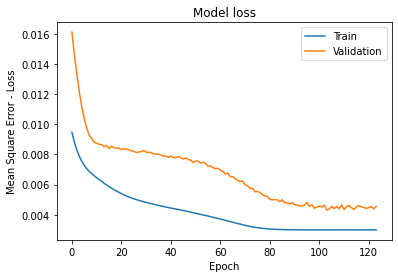

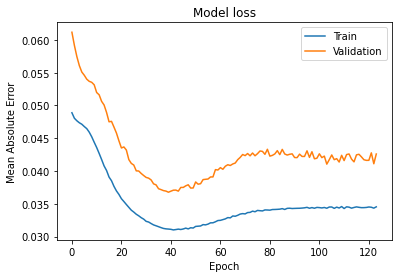

In [8]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Mean Square Error - Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Model loss')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
plot_loss(history)

In [9]:
X_encode = autoencoder.predict(X)
X_encode.shape = (X_encode.shape[0], X_encode.shape[2])
new_df = pd.DataFrame(X_encode)
df.reset_index(inplace = True)
new_df['price'] = df['price']

In [10]:
n_days = 30
length = 30
length_of_sequences = [length for x in range(3500)]

X_train, y_train = get_X_y(new_df, n_days, length_of_sequences)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
model = init_model()
es = EarlyStopping(monitor = 'val_loss',mode = 'min' , verbose = 1, patience = 20, restore_best_weights = True)
history = model.fit(np.array(X_train), y_train,
                    validation_split = 0.3,
                   callbacks = [es], 
                   epochs = 1000, 
                   batch_size = 32)
                   #shuffle = True)

Epoch 1/1000
77/77 [==============================] - 10s 125ms/step - loss: 0.0250 - mae: 0.1120 - val_loss: 0.0134 - val_mae: 0.0895
Epoch 2/1000
77/77 [==============================] - 9s 114ms/step - loss: 0.0150 - mae: 0.0941 - val_loss: 0.0126 - val_mae: 0.0872
Epoch 3/1000
77/77 [==============================] - 6s 83ms/step - loss: 0.0136 - mae: 0.0904 - val_loss: 0.0118 - val_mae: 0.0821
Epoch 4/1000
77/77 [==============================] - 6s 83ms/step - loss: 0.0125 - mae: 0.0857 - val_loss: 0.0105 - val_mae: 0.0770
Epoch 5/1000
77/77 [==============================] - 6s 84ms/step - loss: 0.0117 - mae: 0.0809 - val_loss: 0.0101 - val_mae: 0.0743
Epoch 6/1000
77/77 [==============================] - 6s 79ms/step - loss: 0.0106 - mae: 0.0762 - val_loss: 0.0089 - val_mae: 0.0712
Epoch 7/1000
77/77 [==============================] - 6s 81ms/step - loss: 0.0104 - mae: 0.0756 - val_loss: 0.0096 - val_mae: 0.0742
Epoch 8/1000
77/77 [==============================] - 6s 78ms/step

77/77 [==============================] - 6s 78ms/step - loss: 0.0018 - mae: 0.0277 - val_loss: 0.0020 - val_mae: 0.0288
Epoch 63/1000
77/77 [==============================] - 6s 77ms/step - loss: 0.0017 - mae: 0.0264 - val_loss: 0.0021 - val_mae: 0.0300
Epoch 64/1000
77/77 [==============================] - 6s 82ms/step - loss: 0.0018 - mae: 0.0275 - val_loss: 0.0022 - val_mae: 0.0291
Epoch 65/1000
77/77 [==============================] - 6s 80ms/step - loss: 0.0016 - mae: 0.0262 - val_loss: 0.0013 - val_mae: 0.0234
Epoch 66/1000
77/77 [==============================] - 7s 89ms/step - loss: 0.0016 - mae: 0.0258 - val_loss: 0.0019 - val_mae: 0.0295
Epoch 67/1000
77/77 [==============================] - 7s 87ms/step - loss: 0.0016 - mae: 0.0256 - val_loss: 0.0013 - val_mae: 0.0235
Epoch 68/1000
77/77 [==============================] - 6s 80ms/step - loss: 0.0016 - mae: 0.0257 - val_loss: 0.0014 - val_mae: 0.0246
Epoch 69/1000
77/77 [==============================] - 6s 72ms/step - loss: 

77/77 [==============================] - 6s 74ms/step - loss: 8.5442e-04 - mae: 0.0176 - val_loss: 6.8680e-04 - val_mae: 0.0160
Epoch 122/1000
77/77 [==============================] - 6s 75ms/step - loss: 6.9839e-04 - mae: 0.0168 - val_loss: 7.5743e-04 - val_mae: 0.0166
Epoch 123/1000
77/77 [==============================] - 6s 74ms/step - loss: 6.4776e-04 - mae: 0.0164 - val_loss: 7.3625e-04 - val_mae: 0.0170
Epoch 124/1000
77/77 [==============================] - 6s 75ms/step - loss: 6.7086e-04 - mae: 0.0166 - val_loss: 0.0011 - val_mae: 0.0192
Epoch 125/1000
77/77 [==============================] - 6s 78ms/step - loss: 6.9037e-04 - mae: 0.0167 - val_loss: 7.4648e-04 - val_mae: 0.0170
Epoch 126/1000
77/77 [==============================] - 6s 80ms/step - loss: 7.0668e-04 - mae: 0.0165 - val_loss: 6.8004e-04 - val_mae: 0.0156
Epoch 127/1000
77/77 [==============================] - 6s 75ms/step - loss: 6.7492e-04 - mae: 0.0164 - val_loss: 6.8860e-04 - val_mae: 0.0161
Epoch 128/1000
77/

77/77 [==============================] - 5s 70ms/step - loss: 5.5185e-04 - mae: 0.0138 - val_loss: 5.4874e-04 - val_mae: 0.0136
Epoch 179/1000
77/77 [==============================] - 5s 70ms/step - loss: 4.5163e-04 - mae: 0.0134 - val_loss: 6.4105e-04 - val_mae: 0.0152
Epoch 180/1000
77/77 [==============================] - 5s 71ms/step - loss: 4.6101e-04 - mae: 0.0136 - val_loss: 5.7240e-04 - val_mae: 0.0137
Epoch 181/1000
77/77 [==============================] - 5s 70ms/step - loss: 4.5219e-04 - mae: 0.0134 - val_loss: 5.7644e-04 - val_mae: 0.0141
Epoch 182/1000
77/77 [==============================] - 5s 70ms/step - loss: 5.0369e-04 - mae: 0.0138 - val_loss: 6.3791e-04 - val_mae: 0.0139
Epoch 183/1000
77/77 [==============================] - 5s 70ms/step - loss: 5.1033e-04 - mae: 0.0135 - val_loss: 6.0650e-04 - val_mae: 0.0139
Epoch 184/1000
77/77 [==============================] - 5s 69ms/step - loss: 4.8005e-04 - mae: 0.0136 - val_loss: 6.1327e-04 - val_mae: 0.0138
Epoch 185/1000

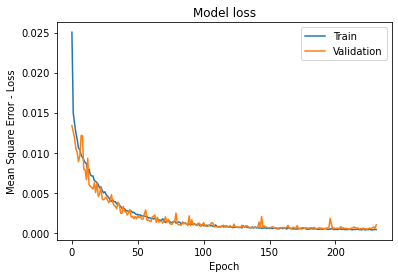

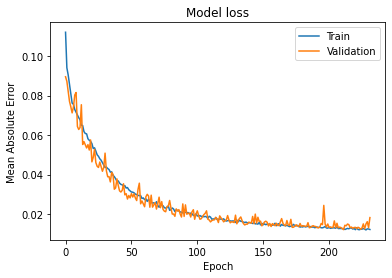

In [13]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Mean Square Error - Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Model loss')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
plot_loss(history)

## TEST

In [14]:
df_test_n = df_test.copy()
df_test_n['price'] = wavelet_transform(df_test_n)[:len(df_test_n)]

df_test = df_test[length:]

prediction = []
for x in range(0,12):
    n = 30*x 
    i = 30 + 30*x
    encode = autoencoder.predict(df_test_n[n:i])
    encode.shape = (1,encode.shape[0], encode.shape[1])
    predict = model.predict(encode)
    prediction.append(predict)

In [15]:
prediction = np.array(prediction)
prediction.shape = (360)

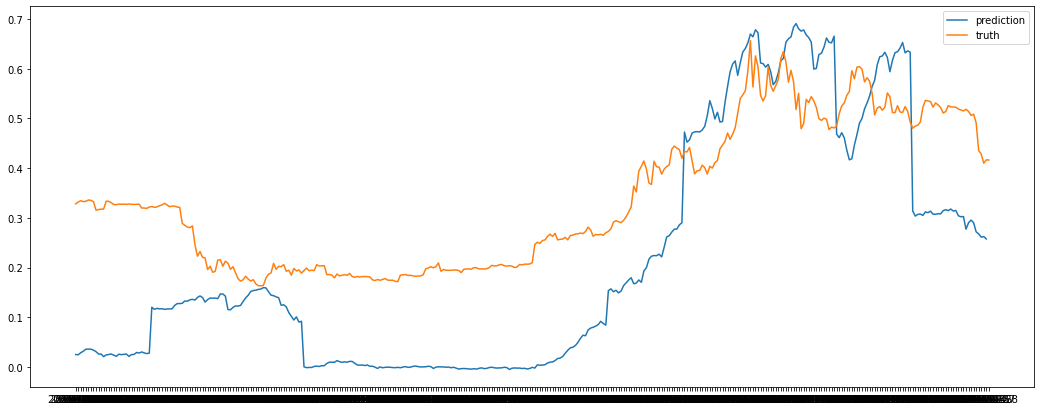

In [16]:
plt.figure(figsize = (18, 7))
plt.plot(prediction, label = 'prediction')
plt.plot(df_test['price'], label = 'truth')
plt.legend()

In [ ]:
df = pd.DataFrame(prediction, df_test)
long = []
for x in len(data) :
    